# CF based recommender system using multi-layered neural networks
## Books for mystery, thriller, and crime
https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home

In [1]:
import sys
sys.path.append('/home/014521052/venv-3.6.6-gpu/lib/python3.6/site-packages')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

### Load Data

In [2]:
user_id_df = pd.read_csv('user_id_map.csv')
print(user_id_df.shape)
user_id_df.head(3)

(876145, 2)


,user_id_csv,user_id
0,0,8842281e1d1347389f2ab93d60773d4d
1,1,72fb0d0087d28c832f15776b0d936598
2,2,ab2923b738ea3082f5f3efcbbfacb218


In [3]:
book_id_df = pd.read_csv('book_id_map.csv')
print(book_id_df.shape)
book_id_df.head(3)

(2360650, 2)


,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076


In [107]:
books_df = pd.read_csv('goodreads_books_mystery_thriller_crime.csv')
books_df.authors = books_df.authors.str.split(pat = ",").str[0].str.split(pat=":").str[1].str.split(pat="'").str[1]
books_df = books_df.rename(columns={'authors': 'author_id'})
books_df.similar_books = books_df.similar_books.str.replace("^\[|\]$","")
print(books_df.shape)
books_df.head(3)

(219235, 29)


,asin,author_id,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,...,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,NaN,37778,3.93,6066814,US,"London, 1196. At the command of Richard the Li...",NaN,Hardcover,https://images.gr-assets.com/books/1328724803m...,False,...,2009.0,Simon & Schuster UK,186,['169353'],"'439108', '522621', '116770', '1275927', '6202...",15,"Crowner Royal (Crowner John Mystery, #13)","Crowner Royal (Crowner John Mystery, #13)",https://www.goodreads.com/book/show/6066814-cr...,6243149
1,B01NCIKAQX,242185,4.33,33394837,US,NaN,NaN,NaN,https://images.gr-assets.com/books/1493114742m...,True,...,NaN,NaN,269,['1052227'],,60,The House of Memory (Pluto's Snitch #2),The House of Memory (Pluto's Snitch #2),https://www.goodreads.com/book/show/33394837-t...,54143148
2,B01ALOWJN0,15104629,3.49,29074697,US,"BATHS, BANKS AND ROMAN INSURRECTION\nDetective...",NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,True,...,NaN,Amazon Digital Services,192,['953679'],,23,The Slaughtered Virgin of Zenopolis (Inspector...,The Slaughtered Virgin of Zenopolis (Inspector...,https://www.goodreads.com/book/show/29074697-t...,49305010


In [4]:
train_df = pd.read_csv('data/train.csv')
print(train_df.shape)
train_df.head(3)

(9876021, 3)


,user_id,book_id,rating
0,eabd6e8c6dc181d8fb5bd65573e9b51b,25365,3
1,f6bf54164ddeba9eb812c024aff1902c,8467921,3
2,7322c5cb2d2dc8a289374e8ae5c4903a,29960804,2


In [5]:
test_df = pd.read_csv('data/test.csv')
print(test_df.shape)
test_df.head(3)

(2549129, 3)


,user_id,book_id,rating
0,4374ea549de7ab51ce7ef59311babfee,17185496,4
1,f2fd8750f9b4b167e2eea57def6b0657,5349974,0
2,0e836dfd49f285f2e564145cd7ab245e,105992,5


### Data merge with user_id and book_id map

In [6]:
temp = pd.merge(train_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
trainSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(trainSet.shape)
trainSet.sample(3)

(9876021, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
2558176,9b9d1449546f1499c5b17f02a67adf4e,23014593,5,373394,33245
9725844,7b54379b95867bf85011a689f14f71dd,26760189,5,399636,2301630
7504997,ae14b278a26b529a7977ff686cd23e63,1075595,2,653191,499112


In [7]:
temp = pd.merge(test_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
testSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(testSet.shape)
testSet.sample(3)

(2549129, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
553649,def264aa828e429d883d626532bc6ff7,6587879,4,295818,5757
30667,8aefe752c1b2cfd791e78993c8bb3ab7,5358,5,60831,834
326713,ff0ed9f550956c8f632328f48e361fe6,968,3,31735,1203


### Data Exploration

In [8]:
train_df.describe()

,book_id,rating
count,9.876021e+06,9.876021e+06
mean,8.298135e+06,3.605505e+00
std,9.922950e+06,1.311846e+00
min,1.640000e+02,0.000000e+00
25%,9.829300e+04,3.000000e+00
50%,2.429135e+06,4.000000e+00
75%,1.608548e+07,5.000000e+00
max,3.649449e+07,5.000000e+00


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876021 entries, 0 to 9876020
Data columns (total 3 columns):
user_id    object
book_id    int64
rating     int64
dtypes: int64(2), object(1)
memory usage: 226.0+ MB


In [10]:
train_df.isnull().sum(axis=0)

user_id    0
book_id    0
rating     0
dtype: int64

In [11]:
num_users = train_df.book_id.nunique()
num_books = train_df.user_id.nunique()

print("Number of users: ", num_users)
print("Number of books: ", num_books)

Number of users:  211013
Number of books:  497178


rating=0, n=627848 (6.357%)
rating=1, n=153336 (1.553%)
rating=2, n=549580 (5.565%)
rating=3, n=2367284 (23.970%)
rating=4, n=3636165 (36.818%)
rating=5, n=2541808 (25.737%)


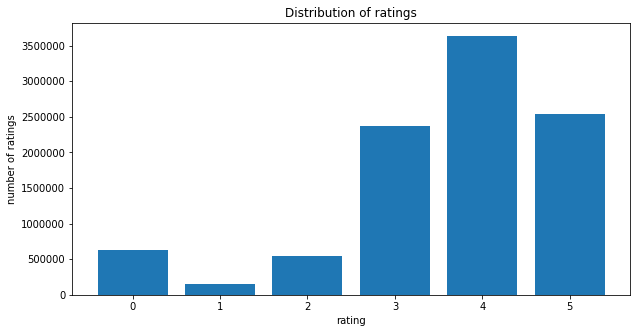

In [12]:
from collections import Counter

counter = Counter(sorted(train_df.rating))

for k,v in counter.items():
    per = v/len(train_df.rating)*100
    print('rating=%d, n=%d (%.3f%%)'%(k, v, per))

#plot class distribution
plt.figure(figsize=(10, 5))
plt.title('Distribution of ratings')
plt.bar(counter.keys(), counter.values())
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

In [13]:
# split dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(trainSet, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((7900816, 5), (1975205, 5))

### Model Creation

In [14]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Tensorflow Version:  1.14.0
Keras Version:  2.2.4-tf


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import dot

In [83]:
def gen_MLP_model(n_factors, lr):
    #user input network
    input_users = Input(shape=[1])
    embed_users = Embedding(num_users + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-6))(input_users)
    users_out = Flatten()(embed_users)
    
    #book input network
    input_books = Input(shape=[1])
    embed_books = Embedding(num_books + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-6))(input_books)
    books_out = Flatten()(embed_books)

    conc_layer = Concatenate()([users_out, books_out])
    x = Dense(64, activation='relu')(conc_layer)
    x = Dropout(0.05)(x)   
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x) 
    x_out = x = Dense(1, activation='relu')(x)
    model = Model([input_users, input_books], x_out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )
      
    return model

In [84]:
def gen_MF_NN_model(n_factors, lr):
    #user input network
    input_users = Input(shape=(1,))
    embed_users = Embedding(num_users + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-4))(input_users)

    #book input network
    input_books = Input(shape=(1,))
    embed_books = Embedding(num_books + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-4))(input_books)
    
    x_dot = Dot(2)([embed_users, embed_books])
    x = Flatten()(x_dot)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)   
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x) 
    x_out = x = Dense(1, activation='relu')(x)
    model = Model([input_users, input_books], x_out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )
      
    return model

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True
    )

### Model Training and Validation

In [96]:
#set parameters
EmbedSize = 15 #30
Op_lr = 1e-1

BATCH_SIZE = 20000

In [102]:
#model = gen_MLP_model(n_factors=EmbedSize, lr=Op_lr)
#model.summary()
model = tf.keras.models.load_model('saved_model/RecSys_NN_model(n_epoch160).h5')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 32)        6752448     input_19[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 32)        15909728    input_20[0][0]                   
____________________________________________________________________________________________

In [103]:
#set training condition
#----------------------
ENABLE = False
#----------------------

if ENABLE == True:
    n_start = 161
    n_iter = n_start+50

    for i in range(n_start, n_iter):
        history = model.fit(
            [X_train.user_id_csv, X_train.book_id_csv], X_train.rating,
            batch_size=BATCH_SIZE,
            epochs=1,
            validation_data=([X_test.user_id_csv, X_test.book_id_csv], X_test.rating)
        ) 

        model_name = 'RecSys_MLP_model(n_epoch%s)'%(i) + '.h5'
        print(model_name)
        model.save('saved_model/'+ model_name)


### Model Evaluation using test dataset

In [104]:
train_results = model.evaluate([X_train.user_id_csv, X_train.book_id_csv], X_train.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, train_results):
  print(name, ': ', value)

loss :  1.0767313566239578
RMSE :  1.0190487


In [106]:
val_results = model.evaluate([X_test.user_id_csv, X_test.book_id_csv], X_test.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, val_results):
  print(name, ': ', value)

loss :  1.6847285656658986
RMSE :  1.2831435


In [105]:
test_results = model.evaluate([testSet.user_id_csv, testSet.book_id_csv], testSet.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, test_results):
  print(name, ': ', value)

loss :  1.706030526445323
RMSE :  1.2914176


### Create Recommendation System with Model Prediction

In [109]:
books = books_df[['book_id', 'author_id', 'average_rating', 'num_pages', 'description', 'similar_books', 'title']]
books_table = pd.merge(books[['book_id', 'author_id', 'average_rating', 'num_pages', 'description', 'similar_books', 'title']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(books_table.shape)
books_table.sample(3)

,book_id,author_id,average_rating,num_pages,description,similar_books,title
132826,7029473,161054,3.74,336.0,Internationally bestselling author Hakan Nesse...,"'7738807', '571526', '2538053', '913882', '612...","Borkmann's Point (Inspector Van Veeteren, #2)"
104031,23566802,12470,4.05,10.0,The new thriller from #1 New York Times bestse...,"'20820995', '22169495', '22609483', '20575424'...","The Burning Room (Harry Bosch, #19)"
29596,13482422,21678,3.97,720.0,A page-turning adaptation of the first season ...,"'18778285', '7331136', '8109216', '13022628', ...","The Killing (The Killing, #1)"


#### User based book recommendation

In [ ]:
def user_based_recommendation(u_id=USER_ID, n_top=N_TOP):
    #create user array
    user_id = np.array([u_id for i in range(len(book_ids))])
    
    #get book list from books_table
    book_list = list(books_table.book_id_csv.unique())
    
    #predict ratings for user
    pred = model.predict([user, np.array(book_list)])
    pred = prediction.reshape(-1)
    
    #sort the array and get the index of N_TOP books
    rec_books = (-pred).argsort()[0:n_top]

    return rec_books

In [ ]:
USER_ID = 1
N_TOP = 5

rec_books = user_based_recommendation(u_id=USER_ID, n_top=N_TOP)
books_table.iloc[rec_books]